Для инвестирования 5 млн руб. и cтавки купона, равного 20% разработайте внебиржевой опцион “Autocallable” с ежеквартальным купоном и возможностью досрочного автоматического погашения опциона каждые 3 месяца, если на ежеквартальную купонную дату текущая цена бумаги с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance) превышает или равна барьеру отзыва.

Если продукт не был отозван досрочно, и на последнюю купонную дату текущая цена worst of превышает или равна барьеру поставки, то продукт погашается с выплатой 100% номинала. Иначе, если хотя бы один базовый актив опциона оказался ниже барьера поставки, то осуществляется выплата денежных средств в сумме, равной эквиваленту «поставки бумаги», бумаги с наибольшим снижением относительно своей первоначальной стоимости, по ее первоначальной цене.

В корзину включить четыре базовых актива, первоначальную стоимость определить на день, предшествующий дате запуска (100%). Установить барьер отзыва 105%, купонный барьер 98%, барьер поставки 90% в процентах от первоначальной стоимости каждого базового актива корзину.

**Дата запуска:** 27-07-2022.

**Дата погашения:** 25-07-2023.

**Даты ежеквартальных наблюдений:** 25-10-2022, 25-01-2023, 25-04-2023.

1. Определить действия на купонные даты (выплачивается купон; выплачивается купон с досрочным погашением продукта; не выплачивается, но запоминается; выплачивается купон за текущий и предыдущие кварталы; производится погашение продукта с «эффектом поставки»).
1. Вычислить финансовый результат по состоянию на 25-04-2023,
определить бумагу с наибольшим снижением относительно своей первоначальной стоимости.
1. Привести иллюстративные графики, на которых отобразить бумагу с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance), купонные даты и действия в эти даты, уровни барьеров отзыва, поставки и купонного барьера, первоначальную стоимость актива,
провести исследование влияния уровней барьеров (барьер отзыва, купонный барьер, барьер поставки) на финансовый результат.
1. Повторить расчеты для метода оценки базовых активов -- средневзвешенная динамика стоимости всех активов (average-of perfomance).

[Примеры графиков и расчетов.](https://www.open-broker.com/files/Presentation_OTC-Option_Autocallable_.pdf)


In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

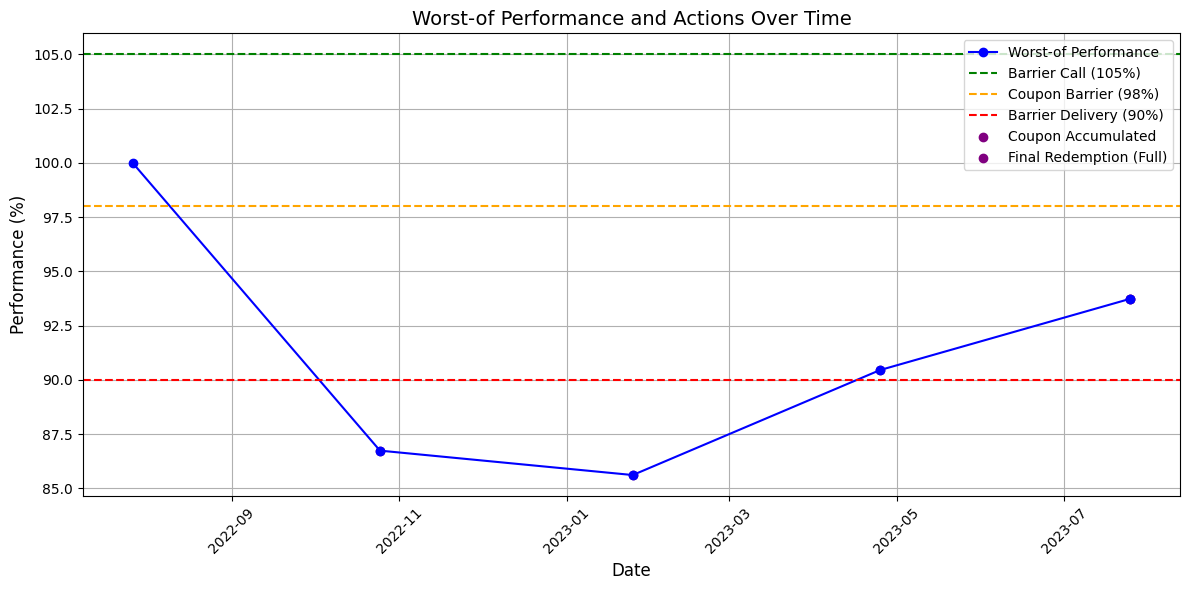

,Date,Action,Worst_of,Payment,Accumulated_Coupon
0,2022-07-27,Start,100.000000,0.0,0.00
1,2022-10-25,Coupon Accumulated,86.742508,0.0,0.05
2,2023-01-25,Coupon Accumulated,85.617535,0.0,0.10
3,2023-04-25,Coupon Accumulated,90.454749,0.0,0.15
4,2023-07-25,Coupon Accumulated,93.736874,0.0,0.20
5,2023-07-25,Final Redemption (Full),93.736874,6000000.0,0.00


In [8]:
# Parameters
INITIAL_PRICE = 100  # Initial price of each asset (%)
NUM_ASSETS = 4  # Number of assets
INVEST_AMOUNT = 5_000_000  # Investment amount (RUB)
COUPON_RATE = 0.05  # Quarterly coupon (5% of nominal)
BARRIER_CALL = 105  # Call barrier (%)
BARRIER_COUPON = 98  # Coupon barrier (%)
BARRIER_DELIVERY = 90  # Delivery barrier (%)
DATES = pd.to_datetime(["2022-07-27", "2022-10-25", "2023-01-25", "2023-04-25", "2023-07-25"])

def generate_prices(num_assets, dates, initial_price):
    """
    Generate random price data for the assets.

    Parameters:
        num_assets (int): Number of assets.
        dates (pd.DatetimeIndex): Dates for price data.
        initial_price (float): Initial price for all assets.

    Returns:
        pd.DataFrame: Price data with an additional column for Worst-of Performance.
    """
    np.random.seed(42)  # For reproducibility
    prices = pd.DataFrame(
        np.random.uniform(85, 115, size=(len(dates), num_assets)),  # Prices between 85% and 115%
        index=dates,
        columns=[f"Asset_{i+1}" for i in range(num_assets)],
    )
    prices.iloc[0, :] = initial_price  # Set initial price at launch date
    prices["Worst_of"] = prices.min(axis=1)  # Calculate worst-of performance
    return prices

def calculate_autocall(prices, barrier_call, barrier_coupon, barrier_delivery, coupon_rate, invest_amount):
    """
    Calculate payments and actions for the autocallable product.

    Parameters:
        prices (pd.DataFrame): Price data including Worst-of Performance.
        barrier_call (float): Call barrier (%).
        barrier_coupon (float): Coupon barrier (%).
        barrier_delivery (float): Delivery barrier (%).
        coupon_rate (float): Quarterly coupon rate.
        invest_amount (float): Investment amount.

    Returns:
        pd.DataFrame: Results of payments and actions over time.
    """
    results = []
    accumulated_coupon = 0
    is_terminated = False

    for i, (date, row) in enumerate(prices.iterrows()):
        worst_of = row["Worst_of"]

        if i == 0:  # Start date
            results.append({
                "Date": date,
                "Action": "Start",
                "Worst_of": worst_of,
                "Payment": 0,
                "Accumulated_Coupon": 0
            })
            continue

        if is_terminated:  # Skip if already terminated
            results.append({
                "Date": date,
                "Action": "Terminated",
                "Worst_of": worst_of,
                "Payment": 0,
                "Accumulated_Coupon": accumulated_coupon
            })
            continue

        if worst_of >= barrier_call:  # Early redemption
            payment = (1 + accumulated_coupon + coupon_rate) * invest_amount
            results.append({
                "Date": date,
                "Action": "Early Redemption",
                "Worst_of": worst_of,
                "Payment": payment,
                "Accumulated_Coupon": 0
            })
            is_terminated = True
        elif worst_of >= barrier_coupon:  # Coupon payment
            payment = coupon_rate * invest_amount
            accumulated_coupon = 0
            results.append({
                "Date": date,
                "Action": "Coupon Paid",
                "Worst_of": worst_of,
                "Payment": payment,
                "Accumulated_Coupon": 0
            })
        else:  # Accumulate coupon
            accumulated_coupon += coupon_rate
            results.append({
                "Date": date,
                "Action": "Coupon Accumulated",
                "Worst_of": worst_of,
                "Payment": 0,
                "Accumulated_Coupon": accumulated_coupon
            })

    # Final redemption
    if not is_terminated:
        final_worst_of = prices.loc[prices.index[-1], "Worst_of"]
        if final_worst_of >= barrier_delivery:
            payment = (1 + accumulated_coupon) * invest_amount
            action = "Final Redemption (Full)"
        else:
            payment = (final_worst_of / 100) * invest_amount  # Delivery of asset
            action = "Final Redemption (Delivery)"
        results.append({
            "Date": prices.index[-1],
            "Action": action,
            "Worst_of": final_worst_of,
            "Payment": payment,
            "Accumulated_Coupon": 0
        })

    return pd.DataFrame(results)

def plot_results(prices, results, barrier_call, barrier_coupon, barrier_delivery):
    """
    Plot the Worst-of Performance and actions over time.

    Parameters:
        prices (pd.DataFrame): Price data including Worst-of Performance.
        results (pd.DataFrame): Results of actions and payments.
        barrier_call (float): Call barrier (%).
        barrier_coupon (float): Coupon barrier (%).
        barrier_delivery (float): Delivery barrier (%).
    """
    plt.figure(figsize=(12, 6))

    # Plot Worst-of Performance
    plt.plot(prices.index, prices["Worst_of"], label="Worst-of Performance", marker='o', color='blue')

    # Plot barriers
    plt.axhline(y=barrier_call, color='green', linestyle='--', label="Barrier Call (105%)")
    plt.axhline(y=barrier_coupon, color='orange', linestyle='--', label="Coupon Barrier (98%)")
    plt.axhline(y=barrier_delivery, color='red', linestyle='--', label="Barrier Delivery (90%)")

    # Mark actions
    for _, row in results.iterrows():
        action = row["Action"]
        date = row["Date"]
        worst_of = row["Worst_of"]
        if action.startswith("Coupon") or "Redemption" in action:
            plt.scatter(date, worst_of, color='purple', label=action if action not in plt.gca().get_legend_handles_labels()[1] else "")

    # Configure plot
    plt.title("Worst-of Performance and Actions Over Time", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Performance (%)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main execution
prices = generate_prices(NUM_ASSETS, DATES, INITIAL_PRICE)
results = calculate_autocall(prices, BARRIER_CALL, BARRIER_COUPON, BARRIER_DELIVERY, COUPON_RATE, INVEST_AMOUNT)
plot_results(prices, results, BARRIER_CALL, BARRIER_COUPON, BARRIER_DELIVERY)
results